# Load Data

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import re
import string
import requests
from PIL import Image
from io import BytesIO
import spacy
from spacy import displacy
from spacy.language import Language
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# read csv file
data = pd.read_csv('https://raw.githubusercontent.com/BhavanishDhamnaskar/mov/main/mobile_recommendation_system_dataset.csv')

In [3]:
# sample of data
data.head(2)

,name,ratings,price,imgURL,corpus
0,"REDMI Note 12 Pro 5G (Onyx Black, 128 GB)",4.2,23999,https://rukminim2.flixcart.com/image/312/312/x...,Storage128 GBRAM6 SystemAndroid 12Processor T...
1,"OPPO F11 Pro (Aurora Green, 128 GB)",4.5,"₹20,999",https://rukminim2.flixcart.com/image/312/312/k...,Storage128 GBRAM6 GBExpandable Storage256GB S...


In [4]:
# columns
data.columns

Index(['name', 'ratings', 'price', 'imgURL', 'corpus'], dtype='object')

In [5]:
# shape of data
data.shape

(2546, 5)

In [6]:
# range of ratings
min  = data['ratings'].min()
max  = data['ratings'].max()
print(f'Range Of Rating = ({min},{max})')

Range Of Rating = (2.9,5.0)


In [7]:
# get rating count
data_rating = dict(data['ratings'].value_counts())
data_rating

{4.3: 584,
 4.2: 514,
 4.4: 422,
 4.5: 318,
 4.1: 242,
 4.6: 152,
 4.0: 105,
 4.7: 87,
 3.9: 62,
 3.8: 22,
 3.7: 11,
 3.6: 5,
 3.0: 4,
 3.5: 4,
 2.9: 4,
 3.3: 4,
 3.1: 3,
 5.0: 2,
 4.8: 1}

<Axes: title={'center': 'Rating Count'}>

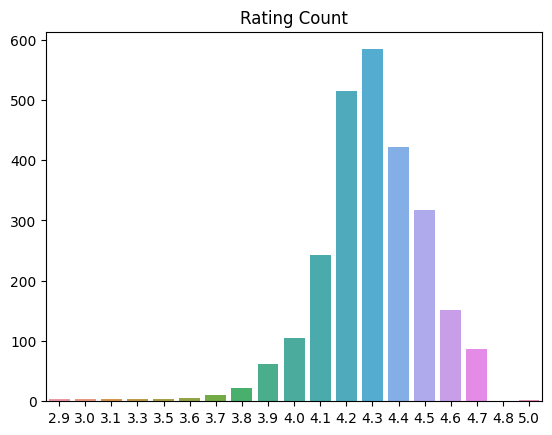

In [8]:
# visualize rating
plt.title('Rating Count')
sns.barplot(x = list(data_rating.keys()), y = list(data_rating.values()))

(-0.5, 237.5, 311.5, -0.5)

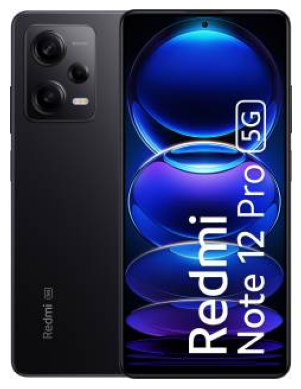

In [9]:
# sample of images
image_url = data['imgURL'][0]

response = requests.get(image_url)

image_data = BytesIO(response.content)

image = Image.open(image_data)

plt.imshow(image)
plt.axis('off')


In [10]:
data['corpus'].isna().sum()

12

In [11]:
nlp = spacy.load('en_core_web_sm')

# Text processing

In [12]:
# drop corpus null values
data.dropna(inplace = True)

In [13]:
# reset index
data = data.reset_index(drop=True)

In [14]:
# new shape
data.shape

(2534, 5)

In [15]:
# get rating average and count
average_rating = dict()
count_rating = dict()
for name in data['name'].unique():
  average_rating[name] = data[data['name'] == name]['ratings'].mean()
  count_rating[name]  = data[data['name'] == name]['ratings'].count()
tmp_average = np.zeros((data.shape[0]))
tmp_count  = np.zeros((data.shape[0]))
for idx in range(data.shape[0]):
  tmp_average[idx]  = average_rating[data['name'][idx]]
  tmp_count[idx] = count_rating[data['name'][idx]]
data['average_rating'] = tmp_average
data['count_rating'] = tmp_count
data.head(2)

,name,ratings,price,imgURL,corpus,average_rating,count_rating
0,"REDMI Note 12 Pro 5G (Onyx Black, 128 GB)",4.2,23999,https://rukminim2.flixcart.com/image/312/312/x...,Storage128 GBRAM6 SystemAndroid 12Processor T...,4.2,1.0
1,"OPPO F11 Pro (Aurora Green, 128 GB)",4.5,"₹20,999",https://rukminim2.flixcart.com/image/312/312/k...,Storage128 GBRAM6 GBExpandable Storage256GB S...,4.5,1.0


In [16]:
# process text
def text_proc(text):
  text = ''.join([char for char in text if char not in string.punctuation])


  doc = nlp(text.lower())

  tokens = [token.lemma_ for token in doc]

  garbage = ['(',')' , ' ',',',':','\n']

  tokens = [token for token in tokens if not nlp.vocab[token].is_stop and token not in garbage]

  return ' '.join(tokens)

In [17]:
# apply process
data['proc_text'] = data['corpus'].apply(text_proc)

In [18]:
data['proc_text'][:3]

0    storage128 gbram6 systemandroid 12processor ty...
1    storage128 gbram6 gbexpandable storage256 gb s...
2    storage64 gbram4 systemandroid 11processor spe...
Name: proc_text, dtype: object

In [19]:
# add BOW
vectorizer = CountVectorizer(max_features=1000)
vectors = vectorizer.fit_transform(data['corpus'].tolist()).toarray()
vectors = pd.DataFrame( vectors , columns =
                                    vectorizer.get_feature_names_out())

data = pd.concat((data,vectors),axis = 1)
data.head(2)

,name,ratings,price,imgURL,corpus,average_rating,count_rating,proc_text,00,000,...,water,waterdrop,wide,widescreen,will,with,xdr,xensation,you,zoom
0,"REDMI Note 12 Pro 5G (Onyx Black, 128 GB)",4.2,23999,https://rukminim2.flixcart.com/image/312/312/x...,Storage128 GBRAM6 SystemAndroid 12Processor T...,4.2,1.0,storage128 gbram6 systemandroid 12processor ty...,0,2,...,0,0,0,0,0,0,0,0,0,0
1,"OPPO F11 Pro (Aurora Green, 128 GB)",4.5,"₹20,999",https://rukminim2.flixcart.com/image/312/312/k...,Storage128 GBRAM6 GBExpandable Storage256GB S...,4.5,1.0,storage128 gbram6 gbexpandable storage256 gb s...,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# cosine similarity
cos_sim = cosine_similarity(vectors)
cos_sim.shape

(2534, 2534)

In [21]:
def get_recommendations(active_price = False , active_rate = False ,mobile = False ,rate = '' , price = '',name = ''):
     # besed on mobile description and similarity of mobiles
    if mobile:

     mobile_index = data[data['name']==name].index[0]
     mobile_index

     similarity_array = cos_sim[mobile_index]

     similar_10_mobiles = sorted(list(enumerate(similarity_array)),reverse=True,key=lambda x:x[1])[1:11]

     tmp_k , tmp_v  = [], []
     for i in similar_10_mobiles:
         tmp_k.append(data['name'].iloc[i[0]])
         tmp_v.append(i[1])


     recommended_df = pd.DataFrame(tmp_k, columns=['Recommended Mobiles'])
     recommended_df['Score'] = tmp_v


     return recommended_df

    # based on price
    elif active_price :

     if price == 'low':

       tmp_k ,tmp_p = data.sort_values('price')['name'][:10].tolist()  ,data.sort_values('price')['price'][:10].tolist()

       recommended_df = pd.DataFrame(tmp_k, columns=['Recommended Mobiles'])
       recommended_df['Price'] = tmp_p

       return recommended_df

     elif price == 'high':

       tmp_k ,tmp_p = data.sort_values('price',ascending=False)['name'].tolist()[:10]  ,data.sort_values('price',ascending=False)['price'].tolist()[:10]

       recommended_df = pd.DataFrame(tmp_k, columns=['Recommended Mobiles'])
       recommended_df['Price'] = tmp_p

       return recommended_df

     elif price == 'random':

       tmp_k  = np.array(data.sample(n = 10)[['name','price']])

       recommended_df = pd.DataFrame(tmp_k, columns=['Recommended Mobiles' , 'Price'])

       return recommended_df


     else : return 'Enter price from ["low","high","random"]'

    # based on rate

    elif active_rate :

     if rate == 'low':

       tmp_k ,tmp_p = data.sort_values('ratings')['name'][:10].tolist()  ,data.sort_values('ratings')['ratings'][:10].tolist()

       recommended_df = pd.DataFrame(tmp_k, columns=['Recommended Mobiles'])
       recommended_df['Rate'] = tmp_p

       return recommended_df

     elif rate == 'high':

       tmp_k ,tmp_p = data.sort_values('ratings',ascending=False)['name'].tolist()[:10]  ,data.sort_values('ratings',ascending=False)['ratings'].tolist()[:10]

       recommended_df = pd.DataFrame(tmp_k, columns=['Recommended Mobiles'])
       recommended_df['Rate'] = tmp_p

       return recommended_df

     elif rate == 'random':

       tmp_k  = np.array(data.sample(n = 10)[['name','ratings']])

       recommended_df = pd.DataFrame(tmp_k, columns=['Recommended Mobiles' , 'Rate'])

       return recommended_df

     else : return 'Enter rate from ["low","high","random"]'
    return 'Error'

In [22]:
def visual_mobile(recommended):
  tmp_image = []
  fig,axs = plt.subplots(figsize = (15,25))
  for i in range(recommended.shape[0]):
    plt.subplot(5,2,i+1)
    name = recommended['Recommended Mobiles'][i]
    price ,rate  = list(data[data['name']== name]['price'])[0] , list(data[data['name'] == name]['ratings'])[0]
    plt.title(f'Name = {name}\nPrice = {price}\nRate = {rate}')

    image_url = list(data[data['name'] == name]['imgURL'])[0]

    response = requests.get(image_url)

    image_data = BytesIO(response.content)

    image = Image.open(image_data)

    plt.imshow(image)

    plt.axis('off')


In [23]:
get_recommendations(mobile = True , name = data['name'][15])

,Recommended Mobiles,Score
0,"OnePlus 9 Pro 5G (Pine Green, 256 GB)",1.000000
1,"OnePlus 9 Pro 5G (Morning Mist, 256 GB)",1.000000
2,"OnePlus 9 Pro 5G (Pine Green, 256 GB)",1.000000
3,"OnePlus 9 Pro 5G (Stellar Black, 256 GB)",0.968246
4,"OnePlus 9 Pro 5G (Stellar Black, 128 GB)",0.875000
5,"OnePlus 9 Pro (Pine Green, 128 GB)",0.875000
6,"OnePlus 9 Pro 5G (Morning Mist, 128 GB)",0.875000
7,"OnePlus 9 Pro 5G (Stellar Black, 128 GB)",0.875000
8,"OnePlus 9 Pro (Pine Green, 128 GB)",0.875000
9,"OnePlus 9 Pro 5G (Morning Mist, 128 GB)",0.875000


In [24]:
get_recommendations(active_price = True , price = 'low')

,Recommended Mobiles,Price
0,"SAMSUNG Galaxy A10s (Black, 32 GB)",10000
1,"APPLE iPhone 14 Pro (Deep Purple, 128 GB)",10073
2,"APPLE iPhone 14 Pro (Space Black, 128 GB)",10073
3,"APPLE iPhone 14 Pro (Gold, 128 GB)",10073
4,"APPLE iPhone 14 Pro (Silver, 128 GB)",10073
5,"SAMSUNG M02s (Black, 64 GB)",10190
6,"Redmi 9 (Sporty Orange, 64 GB)",10280
7,"REDMI 9 Activ (Carbon Black, 64 GB)",10300
8,"REDMI 12C (Mint Green, 128 GB)",10390
9,"REDMI 10A SPORT (CHARCOAL BLACK, 128 GB)",10397


In [25]:
get_recommendations(active_price = True , price = 'high')

,Recommended Mobiles,Price
0,"OPPO A3s (Red, 16 GB)","₹9,990"
1,"OPPO A12 (Blue, 32 GB)","₹9,990"
2,"OPPO A83 (Champagne, 16 GB)","₹9,990"
3,"OPPO A16E (Blue, 32 GB)","₹9,990"
4,"OPPO A17K (Gold, 64 GB)","₹9,990"
5,"OPPO A37f (Grey, 16 GB)","₹9,990"
6,"OPPO A83 (Red, 16 GB)","₹9,990"
7,"OPPO A17K (Gold, 64 GB)","₹9,990"
8,"OPPO A16k (Midnight Black, 32 GB)","₹9,990"
9,"OPPO A16E (White, 32 GB)","₹9,900"


In [26]:
get_recommendations(active_price = True , price = 'random')

,Recommended Mobiles,Price
0,"APPLE iPhone SE (White, 256 GB)",24546
1,"SAMSUNG Galaxy A23 (Peach, 128 GB)",17499
2,"vivo Y02 (Cosmic Grey, 32 GB)",8499
3,"vivo X90 Pro (Legendary Black, 256 GB)",19463
4,"OnePlus 7T (Frosted Silver, 256 GB)",29547
5,"MOTOROLA Edge 30 Fusion (Solar Gold, 128 GB)",30537
6,"REDMI 12C (Matte Black, 128 GB)",9779
7,"vivo T2 5G (Nitro Blaze, 128 GB)",20999
8,"APPLE iPhone 6s (Gold, 64 GB)",15537
9,"APPLE iPhone 13 mini (Midnight, 256 GB)",6463


<ipython-input-22-8ae33662e1fd>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5,2,i+1)


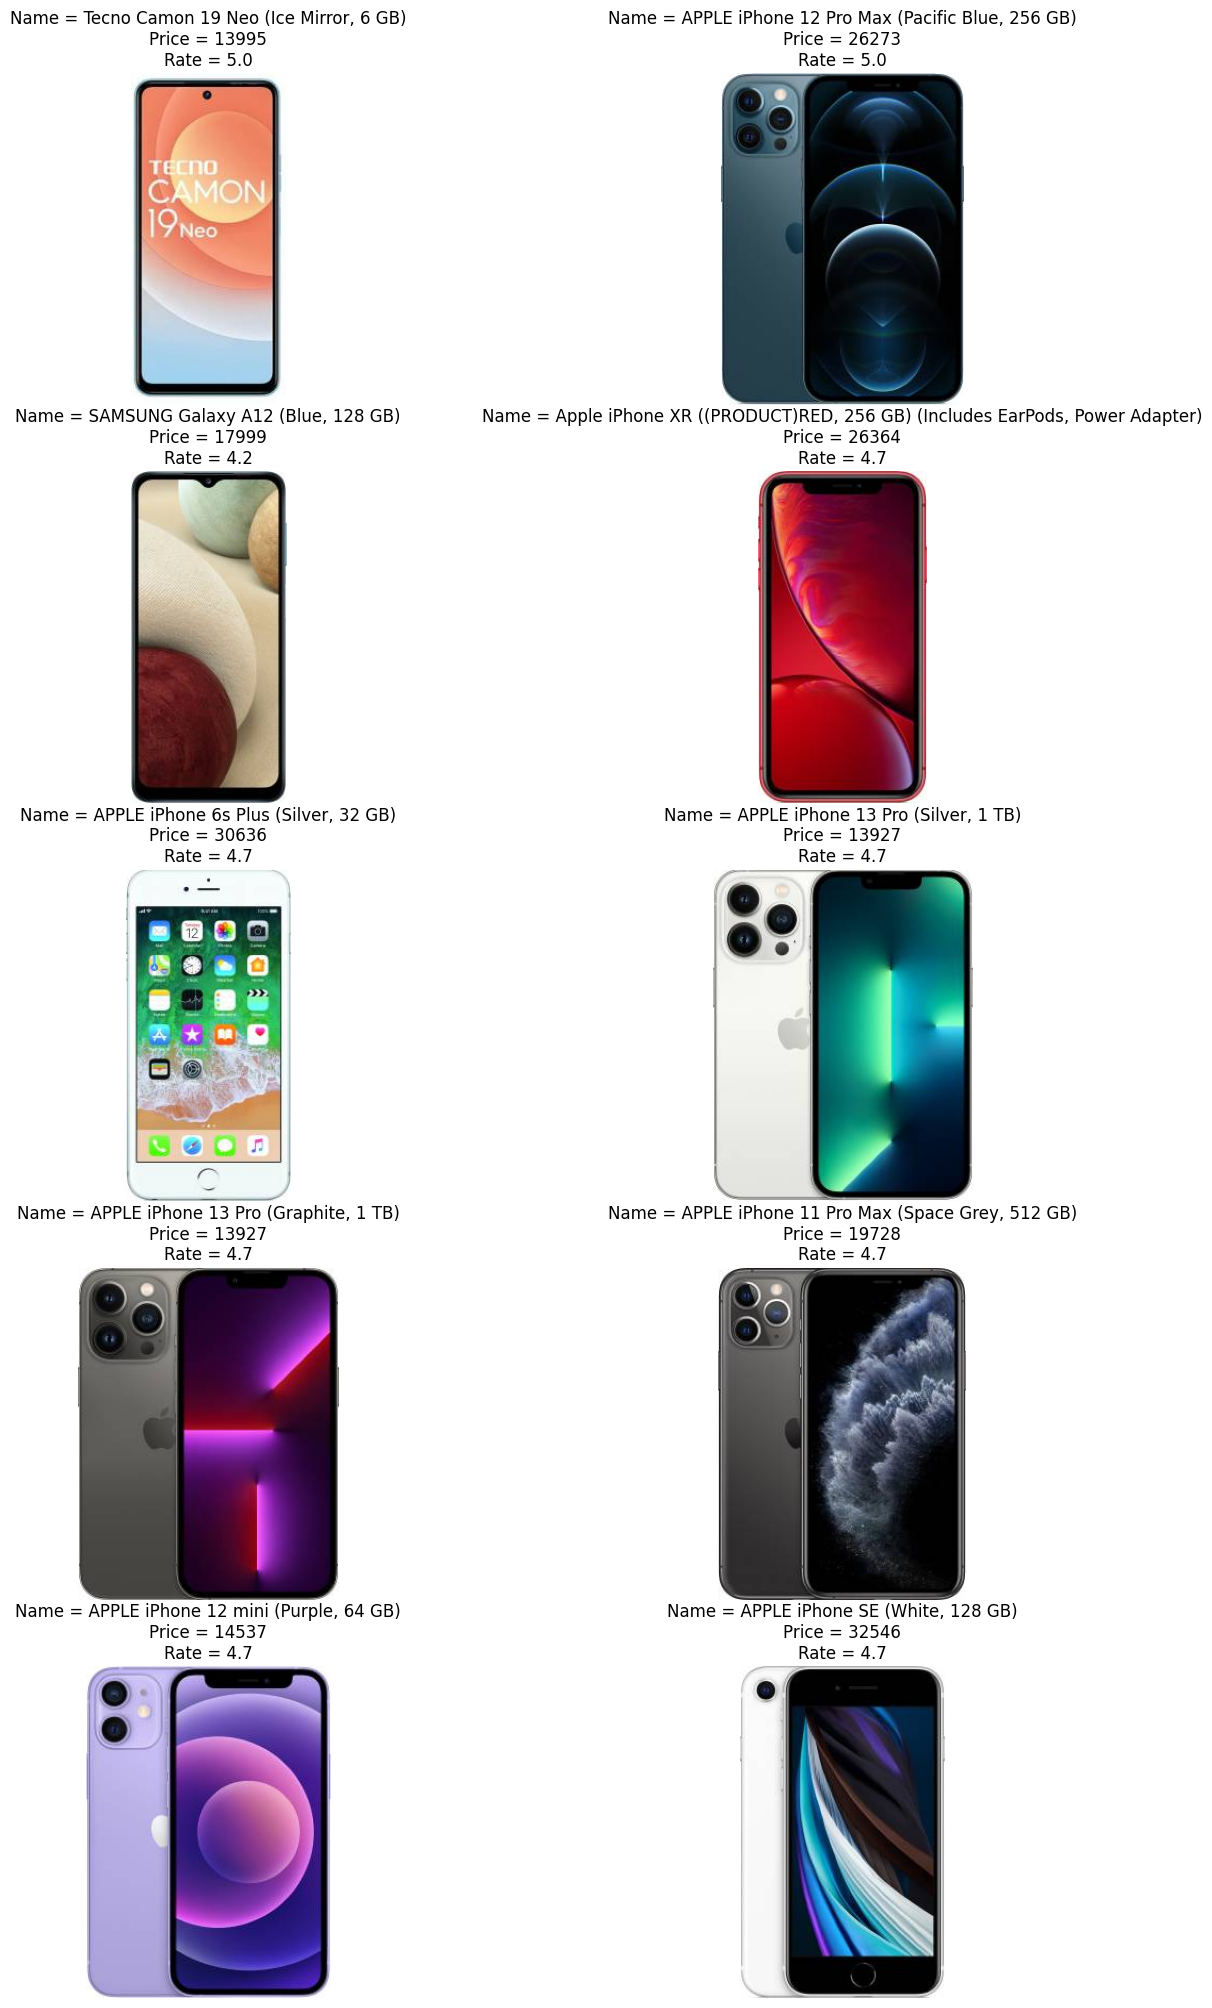

In [27]:
recommended = get_recommendations(active_rate = True , rate = 'high')
visual_mobile(recommended)

In [28]:
get_recommendations(active_rate = True , rate = 'low')

,Recommended Mobiles,Rate
0,"SAMSUNG Galaxy Z Fold4 5G (Phantom Black, 512 GB)",2.9
1,"SAMSUNG Galaxy A50s (Prism Crush Black, 128 GB)",2.9
2,"SAMSUNG Galaxy Z Fold4 5G (Graygreen, 512 GB)",2.9
3,"SAMSUNG Galaxy A52s 5G (Awesome Violet, 128 GB)",2.9
4,"REDMI 12C (Lavender Purple, 6 GB)",3.0
5,"REDMI 12c (Mint Green, 6 GB)",3.0
6,"REDMI 12C (Royal Blue, 6 GB)",3.0
7,"REDMI 12C (Matte Black, 6 GB)",3.0
8,"OPPO A15s (Dynamic Black, 64 GB)",3.1
9,"OPPO R1 R829 (Black, 16 GB)",3.1


In [29]:
get_recommendations(active_rate = True , rate = 'random')

,Recommended Mobiles,Rate
0,"realme C30 (Bamboo Green, 32 GB)",4.1
1,"Mi 10T (Lunar Silver, 128 GB)",4.1
2,"APPLE iPhone 6 Plus (Space Grey, 16 GB)",4.5
3,"SAMSUNG Galaxy S22 Ultra 5G (Phantom White, 25...",4.2
4,"vivo Y27 (Burgundy Black, 128 GB)",4.5
5,"MOTOROLA Edge 30 Pro (Stardust White, 128 GB)",4.0
6,"APPLE iPhone 7 (Black, 128 GB)",4.5
7,"Redmi Note 7 Pro (Space Black, 128 GB)",4.5
8,SAMSUNG Metro 313,4.1
9,"Tecno Camon 19 Pro 5G (Cedar Green, 128 GB)",4.7


In [30]:
get_recommendations(active_rate = True )

'Enter rate from ["low","high","random"]'